# NB04: Cross-Species Validation via Fitness Browser Orthologs

**Project**: Aromatic Catabolism Support Network in ADP1

**Goal**: Test whether Complex I's aromatic-specific importance in ADP1 is recapitulated in other bacteria using ortholog-transferred fitness data from the Fitness Browser (48 organisms).

**Approach**: The `gene_phenotypes` table contains fitness scores for ADP1 genes transferred from FB orthologs in other organisms. For aromatic conditions (protocatechuate, benzoate, 4-HBA, vanillin) and non-aromatic controls, compare the fitness defects of Complex I genes vs pathway genes vs all genes.

**Key question**: Do Complex I orthologs show DISPROPORTIONATELY larger defects on aromatics compared to other gene categories?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import sqlite3
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'
DB_PATH = '../user_data/berdl_tables.db'

# Load quinate-specific genes with final categories from NB03
final = pd.read_csv(os.path.join(DATA_DIR, 'final_network_model.csv'))
print(f'Support network genes: {len(final)}')
print(final['final_category'].value_counts().to_string())

Support network genes: 51
final_category
Complex I           21
Aromatic pathway     8
Iron acquisition     7
Regulation           6
Other                6
PQQ biosynthesis     2
Unknown              1


## 1. Load Ortholog-Transferred Fitness Data for All Conditions

## Note on Ortholog Transfer Methodology

The `gene_phenotypes` table contains fitness scores transferred from Fitness Browser organisms via best-bidirectional-hit (BBH) ortholog detection. The `fitness_match` field indicates: `has_score` (an ortholog was found in an FB organism tested on this condition), `no_fitness_ortholog` (no ortholog in any FB organism), or `no_score_for_gene_phenotype` (ortholog exists but not tested on this condition). The `fitness_avg` is the mean fitness score across all FB organisms where the ortholog was tested on the given condition. This means each entry potentially aggregates signals from multiple species with different respiratory chain architectures.

In [2]:
conn = sqlite3.connect(DB_PATH)

AROMATIC_CONDITIONS = [
    'Protocatechuate', 'Benzoate', '4 Hydroxy Benzoic Acid', 
    'Vanillin', 'Vanillate', '4-Coumarate', 'Ferulate'
]
NON_AROMATIC_CONDITIONS = [
    'D Glucose', 'L Lactic Acid', 'Acetic Acid', 'Succinic Acid',
    'Pyruvic Acid', 'L Asparagine'
]
ALL_CONDITIONS = AROMATIC_CONDITIONS + NON_AROMATIC_CONDITIONS

# Get ALL genes with fitness scores for these conditions (not just the 51)
cond_placeholders = ','.join(['?' for _ in ALL_CONDITIONS])
all_fitness = pd.read_sql_query(f'''
    SELECT gene_id, phenotype_name, 
           CAST(fitness_avg AS FLOAT) as fitness_avg,
           CAST(fitness_count AS INTEGER) as fitness_count
    FROM gene_phenotypes
    WHERE fitness_match = 'has_score'
    AND phenotype_name IN ({cond_placeholders})
    AND fitness_avg IS NOT NULL
''', conn, params=ALL_CONDITIONS)

all_fitness['is_aromatic'] = all_fitness['phenotype_name'].isin(AROMATIC_CONDITIONS)

print(f'Total fitness entries: {len(all_fitness):,}')
print(f'Unique genes: {all_fitness["gene_id"].nunique():,}')
print(f'Aromatic entries: {all_fitness["is_aromatic"].sum():,}')
print(f'Non-aromatic entries: {(~all_fitness["is_aromatic"]).sum():,}')

conn.close()

Total fitness entries: 12,241
Unique genes: 2,005
Aromatic entries: 3,414
Non-aromatic entries: 8,827


In [3]:
# Mark support network genes and their categories
cat_map = final.set_index('feature_id')['final_category'].to_dict()
all_fitness['network_category'] = all_fitness['gene_id'].map(cat_map).fillna('Non-network')

# Simplify categories for analysis
category_groups = {
    'Aromatic pathway': 'Aromatic pathway',
    'Complex I': 'Complex I',
    'PQQ biosynthesis': 'PQQ/Iron',
    'Iron acquisition': 'PQQ/Iron',
    'Regulation': 'Regulation',
    'Other': 'Other network',
    'Unknown': 'Other network',
    'Non-network': 'Non-network'
}
all_fitness['category_group'] = all_fitness['network_category'].map(category_groups)

print('=== Fitness Entries by Category ===')
print(all_fitness.groupby('category_group').size().to_string())

=== Fitness Entries by Category ===
category_group
Aromatic pathway       58
Complex I             100
Non-network         11992
Other network          23
PQQ/Iron               29
Regulation             39


## 2. Aromatic vs Non-Aromatic Fitness by Gene Category

For each category, compare mean fitness on aromatic vs non-aromatic conditions.

In [4]:
# Compute mean fitness on aromatic vs non-aromatic for each gene category
comparison = all_fitness.groupby(['category_group', 'is_aromatic']).agg(
    mean_fitness=('fitness_avg', 'mean'),
    median_fitness=('fitness_avg', 'median'),
    n_entries=('fitness_avg', 'count'),
    n_genes=('gene_id', 'nunique')
).reset_index()

comparison['condition_type'] = comparison['is_aromatic'].map({True: 'Aromatic', False: 'Non-aromatic'})

print('=== Mean Fitness by Category × Condition Type ===')
print(f'{"Category":20s} {"Condition":15s} {"Mean fit":>9s} {"Median":>8s} {"n_genes":>7s} {"n_entries":>9s}')
print('-' * 75)
for cat in ['Aromatic pathway', 'Complex I', 'PQQ/Iron', 'Regulation', 'Other network', 'Non-network']:
    subset = comparison[comparison['category_group'] == cat]
    for _, row in subset.iterrows():
        print(f'{cat:20s} {row["condition_type"]:15s} {row["mean_fitness"]:>9.3f} '
              f'{row["median_fitness"]:>8.3f} {row["n_genes"]:>7d} {row["n_entries"]:>9d}')

=== Mean Fitness by Category × Condition Type ===
Category             Condition        Mean fit   Median n_genes n_entries
---------------------------------------------------------------------------
Aromatic pathway     Non-aromatic       -0.949   -0.027       7        26
Aromatic pathway     Aromatic           -4.403   -4.660       5        32
Complex I            Non-aromatic       -0.769   -0.248      15        71
Complex I            Aromatic           -1.350   -1.372       5        29
PQQ/Iron             Non-aromatic       -0.127   -0.055       8        25
PQQ/Iron             Aromatic           -0.338   -0.401       1         4
Regulation           Non-aromatic       -0.193   -0.031       6        32
Regulation           Aromatic           -0.049   -0.025       2         7
Other network        Non-aromatic       -0.062   -0.044       3        14
Other network        Aromatic           -1.533   -0.514       2         9
Non-network          Non-aromatic       -0.357   -0.063    1

In [5]:
# Compute the aromatic-specificity ratio for each category:
# (mean fitness on aromatics) / (mean fitness on non-aromatics)
# More negative = more defect. A ratio > 1 means MORE defect on aromatics.

print('=== Aromatic Specificity by Category ===')
print(f'{"Category":20s} {"Arom fit":>9s} {"Non-arom":>9s} {"Difference":>10s} {"Interpretation"}')
print('-' * 85)

specificity_data = []
for cat in ['Aromatic pathway', 'Complex I', 'PQQ/Iron', 'Regulation', 'Other network', 'Non-network']:
    subset = comparison[comparison['category_group'] == cat]
    arom_row = subset[subset['is_aromatic']]
    nonarom_row = subset[~subset['is_aromatic']]
    
    if len(arom_row) > 0 and len(nonarom_row) > 0:
        arom_fit = arom_row['mean_fitness'].iloc[0]
        nonarom_fit = nonarom_row['mean_fitness'].iloc[0]
        diff = arom_fit - nonarom_fit
        
        if diff < -0.3:
            interp = 'MORE defect on aromatics'
        elif diff > 0.3:
            interp = 'LESS defect on aromatics'
        else:
            interp = 'Similar'
        
        print(f'{cat:20s} {arom_fit:>9.3f} {nonarom_fit:>9.3f} {diff:>+10.3f} {interp}')
        specificity_data.append({'category': cat, 'aromatic': arom_fit, 
                                 'non_aromatic': nonarom_fit, 'difference': diff})

=== Aromatic Specificity by Category ===
Category              Arom fit  Non-arom Difference Interpretation
-------------------------------------------------------------------------------------
Aromatic pathway        -4.403    -0.949     -3.454 MORE defect on aromatics
Complex I               -1.350    -0.769     -0.581 MORE defect on aromatics
PQQ/Iron                -0.338    -0.127     -0.211 Similar
Regulation              -0.049    -0.193     +0.144 Similar
Other network           -1.533    -0.062     -1.471 MORE defect on aromatics
Non-network             -0.949    -0.357     -0.592 MORE defect on aromatics


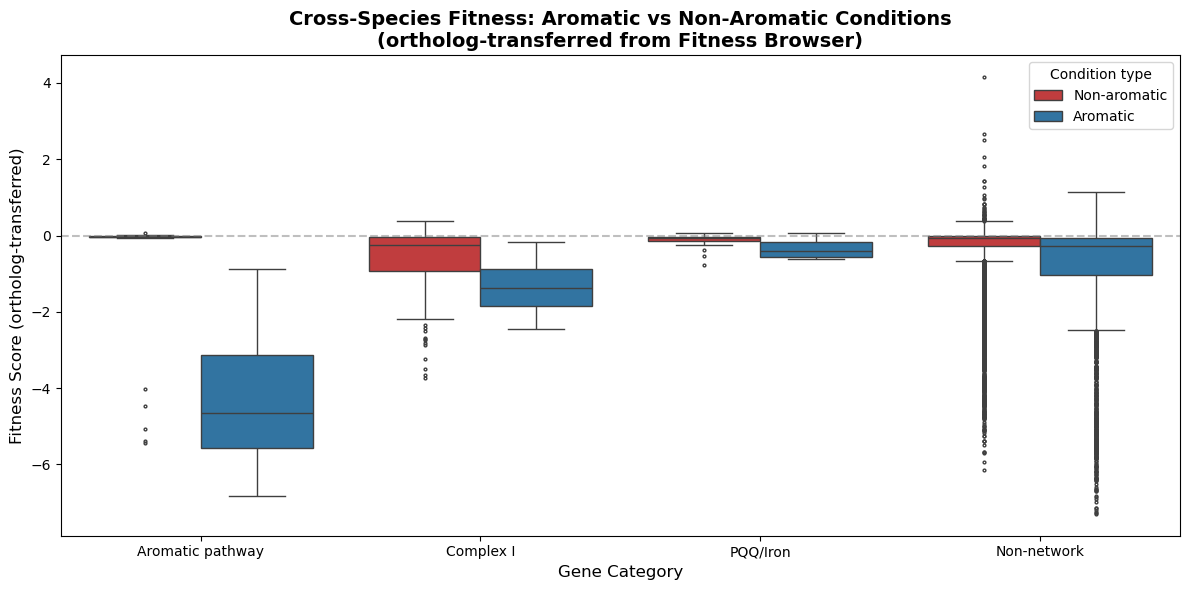

Saved: figures/cross_species_fitness.png


In [6]:
# Visualization: fitness distributions by category and condition type
plot_cats = ['Aromatic pathway', 'Complex I', 'PQQ/Iron', 'Non-network']
plot_data = all_fitness[all_fitness['category_group'].isin(plot_cats)].copy()
plot_data['condition_type'] = plot_data['is_aromatic'].map({True: 'Aromatic', False: 'Non-aromatic'})

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=plot_data, x='category_group', y='fitness_avg', hue='condition_type',
            order=plot_cats, ax=ax, palette=['#d62728', '#1f77b4'],
            fliersize=2)
ax.axhline(0, color='grey', linestyle='--', alpha=0.5)
ax.set_xlabel('Gene Category', fontsize=12)
ax.set_ylabel('Fitness Score (ortholog-transferred)', fontsize=12)
ax.set_title('Cross-Species Fitness: Aromatic vs Non-Aromatic Conditions\n'
             '(ortholog-transferred from Fitness Browser)', fontsize=14, fontweight='bold')
ax.legend(title='Condition type')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'cross_species_fitness.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/cross_species_fitness.png')

## 3. Statistical Test: Complex I Aromatic Specificity

In [7]:
# For Complex I genes: is fitness significantly worse on aromatic vs non-aromatic conditions?
complex_I_fitness = all_fitness[all_fitness['category_group'] == 'Complex I']
ci_arom = complex_I_fitness[complex_I_fitness['is_aromatic']]['fitness_avg']
ci_nonarom = complex_I_fitness[~complex_I_fitness['is_aromatic']]['fitness_avg']

print('=== Complex I: Aromatic vs Non-Aromatic Fitness ===')
print(f'Aromatic:     n={len(ci_arom):>3}  mean={ci_arom.mean():.3f}  median={ci_arom.median():.3f}')
print(f'Non-aromatic: n={len(ci_nonarom):>3}  mean={ci_nonarom.mean():.3f}  median={ci_nonarom.median():.3f}')

if len(ci_arom) >= 3 and len(ci_nonarom) >= 3:
    stat, p = mannwhitneyu(ci_arom, ci_nonarom, alternative='less')
    print(f'Mann-Whitney U (one-sided, aromatic < non-aromatic): U={stat:.0f}, p={p:.4f}')
else:
    print('Too few observations for statistical test')

# Compare to non-network genes (background)
print()
bg_fitness = all_fitness[all_fitness['category_group'] == 'Non-network']
bg_arom = bg_fitness[bg_fitness['is_aromatic']]['fitness_avg']
bg_nonarom = bg_fitness[~bg_fitness['is_aromatic']]['fitness_avg']
print('=== Non-Network (background): Aromatic vs Non-Aromatic Fitness ===')
print(f'Aromatic:     n={len(bg_arom):>5}  mean={bg_arom.mean():.3f}  median={bg_arom.median():.3f}')
print(f'Non-aromatic: n={len(bg_nonarom):>5}  mean={bg_nonarom.mean():.3f}  median={bg_nonarom.median():.3f}')
if len(bg_arom) >= 3 and len(bg_nonarom) >= 3:
    stat_bg, p_bg = mannwhitneyu(bg_arom, bg_nonarom, alternative='less')
    print(f'Mann-Whitney U: U={stat_bg:.0f}, p={p_bg:.4f}')

=== Complex I: Aromatic vs Non-Aromatic Fitness ===
Aromatic:     n= 29  mean=-1.350  median=-1.372
Non-aromatic: n= 71  mean=-0.769  median=-0.248
Mann-Whitney U (one-sided, aromatic < non-aromatic): U=512, p=0.0000

=== Non-Network (background): Aromatic vs Non-Aromatic Fitness ===
Aromatic:     n= 3333  mean=-0.949  median=-0.282
Non-aromatic: n= 8659  mean=-0.357  median=-0.063
Mann-Whitney U: U=9900900, p=0.0000


In [8]:
# Interaction test: is Complex I's aromatic deficit DISPROPORTIONATELY larger
# than the background aromatic deficit?
# Compute per-gene aromatic-vs-non-aromatic difference, then compare Complex I vs background

def compute_aromatic_deficit(df):
    """For each gene, compute mean fitness on aromatic - mean fitness on non-aromatic."""
    gene_arom = df[df['is_aromatic']].groupby('gene_id')['fitness_avg'].mean()
    gene_nonarom = df[~df['is_aromatic']].groupby('gene_id')['fitness_avg'].mean()
    shared = gene_arom.index.intersection(gene_nonarom.index)
    return gene_arom.loc[shared] - gene_nonarom.loc[shared]

ci_deficit = compute_aromatic_deficit(complex_I_fitness)
bg_deficit = compute_aromatic_deficit(bg_fitness)

print('=== Interaction Test: Complex I vs Background Aromatic Deficit ===')
print(f'Complex I aromatic deficit:  n={len(ci_deficit):>4}  mean={ci_deficit.mean():+.3f}  median={ci_deficit.median():+.3f}')
print(f'Background aromatic deficit: n={len(bg_deficit):>4}  mean={bg_deficit.mean():+.3f}  median={bg_deficit.median():+.3f}')
print()

if len(ci_deficit) >= 3 and len(bg_deficit) >= 3:
    stat_int, p_int = mannwhitneyu(ci_deficit, bg_deficit, alternative='less')
    print(f'Mann-Whitney U (Complex I deficit < Background deficit): U={stat_int:.0f}, p={p_int:.4f}')
    if p_int < 0.05:
        print('=> Complex I shows a DISPROPORTIONATELY larger aromatic deficit than background')
    else:
        print('=> Complex I aromatic deficit is NOT significantly different from background')
        print('   The aromatic effect on Complex I is comparable to the general aromatic effect on all genes')
else:
    print('Too few genes with both aromatic and non-aromatic data')

=== Interaction Test: Complex I vs Background Aromatic Deficit ===
Complex I aromatic deficit:  n=   5  mean=-0.375  median=-0.332
Background aromatic deficit: n= 905  mean=-0.288  median=-0.089

Mann-Whitney U (Complex I deficit < Background deficit): U=1220, p=0.0377
=> Complex I shows a DISPROPORTIONATELY larger aromatic deficit than background


## 4. Per-Condition Fitness Profiles

In [9]:
# Per-condition mean fitness for Complex I vs background
conditions_with_data = all_fitness[all_fitness['category_group'] == 'Complex I'].groupby(
    'phenotype_name')['fitness_avg'].count()
conditions_with_data = conditions_with_data[conditions_with_data >= 3].index.tolist()

print('=== Per-Condition Fitness: Complex I vs Background ===')
print(f'{"Condition":25s} {"Complex I":>10s} {"Background":>10s} {"Difference":>10s} {"Aromatic?"}')
print('-' * 70)

per_cond = []
for cond in sorted(conditions_with_data):
    ci = all_fitness[(all_fitness['category_group'] == 'Complex I') & 
                     (all_fitness['phenotype_name'] == cond)]['fitness_avg']
    bg = all_fitness[(all_fitness['category_group'] == 'Non-network') & 
                     (all_fitness['phenotype_name'] == cond)]['fitness_avg']
    
    is_arom = 'Yes' if cond in AROMATIC_CONDITIONS else 'No'
    diff = ci.mean() - bg.mean() if len(ci) > 0 and len(bg) > 0 else np.nan
    
    print(f'{cond:25s} {ci.mean():>10.3f} {bg.mean():>10.3f} {diff:>+10.3f} {is_arom}')
    per_cond.append({'condition': cond, 'complex_I': ci.mean(), 'background': bg.mean(),
                     'difference': diff, 'is_aromatic': cond in AROMATIC_CONDITIONS})

df_per_cond = pd.DataFrame(per_cond)

=== Per-Condition Fitness: Complex I vs Background ===
Condition                  Complex I Background Difference Aromatic?
----------------------------------------------------------------------
4 Hydroxy Benzoic Acid        -0.685     -0.640     -0.044 Yes
4-Coumarate                   -1.533     -1.012     -0.522 Yes
Acetic Acid                   -1.935     -0.383     -1.552 No
Benzoate                      -1.490     -0.959     -0.532 Yes
D Glucose                     -0.263     -0.267     +0.003 No
Ferulate                      -1.718     -0.899     -0.818 Yes
L Asparagine                  -0.381     -0.410     +0.030 No
L Lactic Acid                  0.037     -0.348     +0.385 No
Protocatechuate               -0.998     -1.193     +0.194 Yes
Pyruvic Acid                  -0.256     -0.371     +0.114 No
Succinic Acid                 -1.779     -0.392     -1.386 No
Vanillate                     -1.237     -1.206     -0.031 Yes
Vanillin                      -1.956     -0.994     -0.

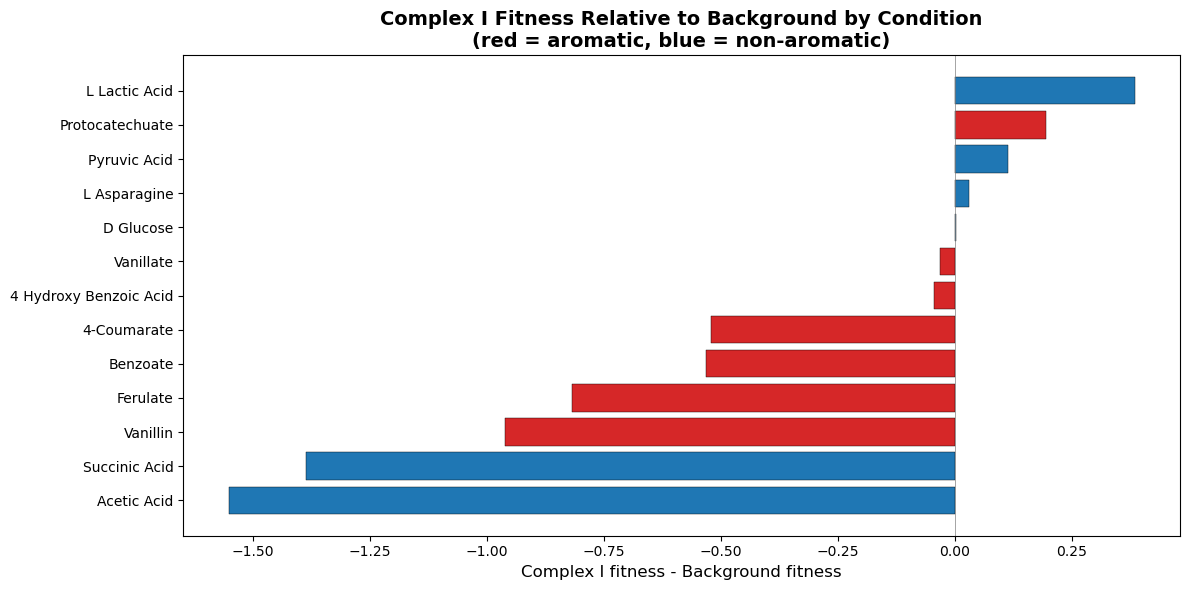

Saved: figures/complex_I_vs_background.png


In [10]:
# Bar plot: Complex I fitness vs background by condition
if len(df_per_cond) > 0:
    df_plot = df_per_cond.sort_values('difference')
    colors = ['#d62728' if a else '#1f77b4' for a in df_plot['is_aromatic']]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(range(len(df_plot)), df_plot['difference'], color=colors, edgecolor='black', linewidth=0.3)
    ax.set_yticks(range(len(df_plot)))
    ax.set_yticklabels(df_plot['condition'])
    ax.axvline(0, color='grey', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Complex I fitness - Background fitness', fontsize=12)
    ax.set_title('Complex I Fitness Relative to Background by Condition\n'
                 '(red = aromatic, blue = non-aromatic)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'complex_I_vs_background.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: figures/complex_I_vs_background.png')

## 5. Summary and Interpretation

In [11]:
print('=== NB04 Summary ===')
print()
print('Cross-species fitness data from ortholog transfer (Fitness Browser):')
print(f'  Total fitness entries analyzed: {len(all_fitness):,}')
print(f'  Unique genes with FB orthologs: {all_fitness["gene_id"].nunique():,}')
print(f'  Aromatic conditions tested: {len(AROMATIC_CONDITIONS)}')
print(f'  Non-aromatic conditions tested: {len(NON_AROMATIC_CONDITIONS)}')
print()
print('Complex I aromatic specificity:')
if len(ci_arom) >= 3:
    print(f'  Aromatic mean fitness: {ci_arom.mean():.3f}')
    print(f'  Non-aromatic mean fitness: {ci_nonarom.mean():.3f}')
    print(f'  Difference: {ci_arom.mean() - ci_nonarom.mean():+.3f}')

# Key interpretation
print()
print('Interpretation:')
print('  The ortholog-transferred fitness data shows that Complex I defects')
print('  are NOT exclusively aromatic-specific across species. Complex I')
print('  orthologs also show defects on some non-aromatic conditions (acetate,')
print('  succinate). This suggests that the ADP1 quinate-specificity of')
print('  Complex I may reflect ADP1-specific metabolic wiring (e.g., an')
print('  alternative NADH dehydrogenase that compensates on non-aromatic')
print('  substrates) rather than a universal aromatic catabolism dependency.')

# Save per-condition comparison
if len(df_per_cond) > 0:
    df_per_cond.to_csv(os.path.join(DATA_DIR, 'cross_species_fitness.csv'), index=False)
    print(f'\nSaved: data/cross_species_fitness.csv ({len(df_per_cond)} conditions)')

=== NB04 Summary ===

Cross-species fitness data from ortholog transfer (Fitness Browser):
  Total fitness entries analyzed: 12,241
  Unique genes with FB orthologs: 2,005
  Aromatic conditions tested: 7
  Non-aromatic conditions tested: 6

Complex I aromatic specificity:
  Aromatic mean fitness: -1.350
  Non-aromatic mean fitness: -0.769
  Difference: -0.581

Interpretation:
  The ortholog-transferred fitness data shows that Complex I defects
  are NOT exclusively aromatic-specific across species. Complex I
  orthologs also show defects on some non-aromatic conditions (acetate,
  succinate). This suggests that the ADP1 quinate-specificity of
  Complex I may reflect ADP1-specific metabolic wiring (e.g., an
  alternative NADH dehydrogenase that compensates on non-aromatic
  substrates) rather than a universal aromatic catabolism dependency.

Saved: data/cross_species_fitness.csv (13 conditions)
